## Data Split and Preprocessing

As discovered Image_Sizing notebook there are two sizes that I will be using for training and testing models:

1. 300x200 for low res images
2. 450x300 for high res images

In this notebook I will prepare data for both sizes.

First I will split labeled dresses data into train, validation and test sets. As we have multilabel proplem (each image can have several labels assigned to it), it is important to have enough representatives of each label in each split set. Therefore I am defining a function to select 10% of each label representatives and then combine them together by removing duplicates.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import random

from timeit import default_timer as timer
from datetime import timedelta

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# load dress attribute dataset and add column of file names corresponding image number
dresses = pd.read_csv('data/dress_attributes.csv', header=0)
dresses.drop('Unnamed: 0', axis=1, inplace=True)
dresses['short_path'] = ['img'+str(i)+'.png' for i in range(len(dresses))]
dresses['low_res_url'] = 'data/img/' + dresses['url']

In [3]:
# function to select test data for a specified column
def select_test_data(col_name, test_split = 0.1, df = dresses):
    """Returns list of indexes for randomly selected 10% of specified attribute"""
    n = df[col_name].sum()
    test_size = round(n*test_split).astype('int64')
    index = df[col_name].sample(test_size).index
    return pd.Series(index)

In [4]:
# split data into test, validation and train
columns = dresses.drop(['url', 'short_path', 'low_res_url'], axis=1).columns

test_index = pd.Series([])
for col_name in columns:
    test_index = pd.concat([test_index, select_test_data(col_name)])
test_index = test_index.drop_duplicates()

train_full_data = dresses.drop(test_index)
test_data = dresses.loc[test_index.values,:]

val_index = pd.Series([])
for col_name in columns:
    val_index = pd.concat([val_index, select_test_data(col_name, df=train_full_data)])
val_index = val_index.drop_duplicates()

validation_data = train_full_data.loc[val_index,:]
train_data = train_full_data.drop(val_index)

# save datasets to files
train_data.to_csv('data/train_images.csv')
test_data.to_csv('data/test_images.csv')
validation_data.to_csv('data/validation_images.csv')

I will now crop the images so that they all are the same ratio and it will be easier to resize them without changing their ratio. I have defined a function for this purpose.

In [5]:
def adjust_ratio(img, target_ratio):
    """Crops the the image to be proportional to target_ratio"""
    width, height = img.size
    img_ratio = height / width
    if img_ratio > target_ratio:
        extra = (height - target_ratio*width)//2
        img = img.crop((0, extra, width, height-extra))
    elif img_ratio < target_ratio:
        extra = (target_ratio*width - height)//2
        img = img.crop((extra, 0, width-extra, height))
    return img

def crop_images(df, target_width, target_height, target_directory,column='url'):
    """Crops and resizes images to the target size and saves to target directory"""
    l = len(df)
    target_ratio = target_height / target_width
    for i in range(l):
        img = Image.open(df.loc[i, column])
        img = adjust_ratio(img, target_ratio)
        img = img.convert('RGB')
        img = img.resize((target_width, target_height))
        img.save(target_directory + 'img' + str(i) + '.png')
        del img

In [6]:
# create directories for each target size
directory = 'data/cropped_images_300x200/'
if not os.path.isdir(directory):
    os.mkdir(directory)

directory2 = 'data/cropped_images_450x300/'
if not os.path.isdir(directory2):
    os.mkdir(directory2)    

In [7]:
# cropping and resizing low res images
Image.MAX_IMAGE_PIXELS = None
start = timer()
crop_images(dresses, target_height=300, target_width=200, 
            target_directory='data/cropped_images_300x200/', column='low_res_url')
end = timer()
print(timedelta(seconds=end-start))

0:15:04.984229


In [8]:
# cropping and resizing high res images
Image.MAX_IMAGE_PIXELS = None
start = timer()
crop_images(dresses, target_height=450, target_width=300, 
            target_directory='data/cropped_images_450x300/', column='url')
end = timer()
print(timedelta(seconds=end-start))

C:\Users\ksushka\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 2. 
  warnings.warn(str(msg))
C:\Users\ksushka\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8552 bytes but only got 8356. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag))


0:31:33.420121


The images are resized appropriatly now. Since there are no actual metrics to explore with this problem. Visually similar dresses are a very subjective thing. However, I still want to get an idea on how my future models will perform. Therefore I will randomly select several images from the test images dataset and from full dataset (in case my machine's capacity will allow to use the full data).

In [9]:
# from test data selecting 5 images to test each model
test_numbers = random.sample(range(len(test_data)),5)

# from all data
all_test_numbers = random.sample(range(len(dresses)),5)

In [10]:
# define function that prints each individual image
def print_image(ind, directory, df, column):
    """Prints image of a given index"""
    img = mpimg.imread(directory+df.loc[ind,column], format='jpeg')
    plt.imshow(img)
    del img

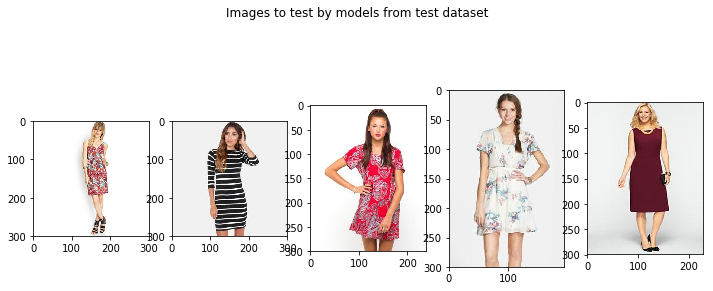

In [11]:
# print images from test dataset
plt.figure(figsize=[12,5])
i = 1
for ind in test_numbers:
    plt.subplot(1,5,i)
    i += 1
    print_image(ind=ind, directory='data/img/', df=test_data.reset_index(), column='url')
plt.suptitle('Images to test by models from test dataset')    
plt.show()

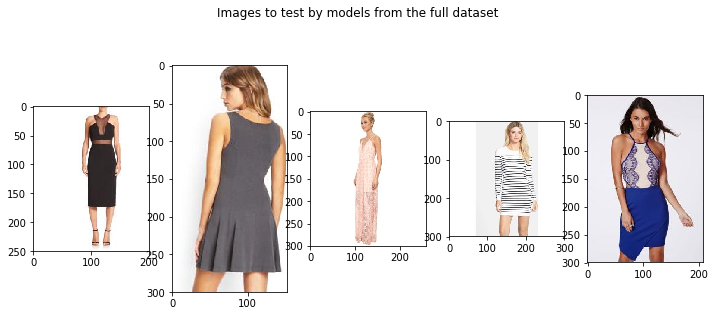

In [12]:
plt.figure(figsize=[12,5])
i = 1
for ind in all_test_numbers:
    plt.subplot(1,5,i)
    i += 1
    print_image(ind=ind, directory='data/img/', df=dresses, column='url')
plt.suptitle('Images to test by models from the full dataset')    
plt.show()

I have also collected some more images to be tested. They don't have labels and therefore I can only use them to test models. 

First dataset contains 101 google images and is good for fast checks.
The second one has over 8000 images and can be a broader source for comparison. I will adjust ratios for both collections (ratios are the same in case of 300x200 and 450x300) and also select 5 random images from each for testing. 

In [13]:
# create dataframe of smaller images dataset
test_dresses = ['dress_img/img'+str(x)+'.png' for x in range(101)]
test_dresses = pd.DataFrame(test_dresses, columns=['url'])
test_dresses.to_csv('data/test_dresses_small.csv')

In [14]:
# create directory to store images
directory = 'data/test_dresses_small/'
if not os.path.isdir(directory):
    os.mkdir(directory)
    
# crop images to the target ratio
target_ratio = 1.5
for i in range(len(test_dresses)):
    img = Image.open(test_dresses.loc[i,'url'])
    img = adjust_ratio(img, target_ratio)
    img = img.convert('RGB')
    img.save(directory+'img'+str(i)+'.png')

In [15]:
# select 5 random images
test_dresses_small = random.sample(range(len(test_dresses)),5)

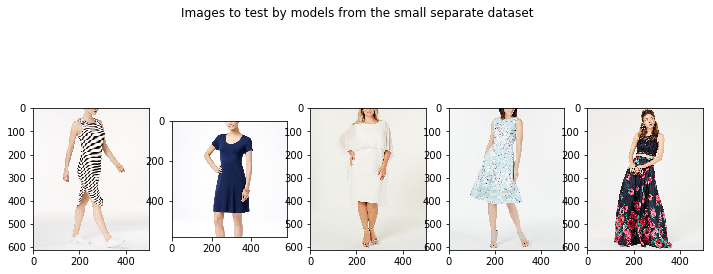

In [16]:
plt.figure(figsize=[12,5])
i = 1
for ind in test_dresses_small:
    plt.subplot(1,5,i)
    i += 1
    print_image(ind=ind, directory='', df=test_dresses, column='url')
plt.suptitle('Images to test by models from the small separate dataset')    
plt.show()

Same for larger collection of images.

In [17]:
# create dataframe of larger images collection
test_large_dresses = ['dress_patterns/img'+str(x)+'.png' for x in range(8642)]
test_large_dresses = pd.DataFrame(test_large_dresses, columns=['url'])
test_large_dresses.to_csv('data/test_dresses_large.csv')

In [18]:
# create directory to store images
directory = 'data/test_dresses_large/'
if not os.path.isdir(directory):
    os.mkdir(directory)

# crop images to the target ratio
target_ratio = 1.5
for i in range(len(test_large_dresses)):
    img = Image.open(test_large_dresses.loc[i,'url'])
    img = adjust_ratio(img, target_ratio)
    img = img.convert('RGB')
    img.save(directory+'img'+str(i)+'.png')

In [19]:
# select 5 random images
test_dresses_large = random.sample(range(len(test_large_dresses)),5)

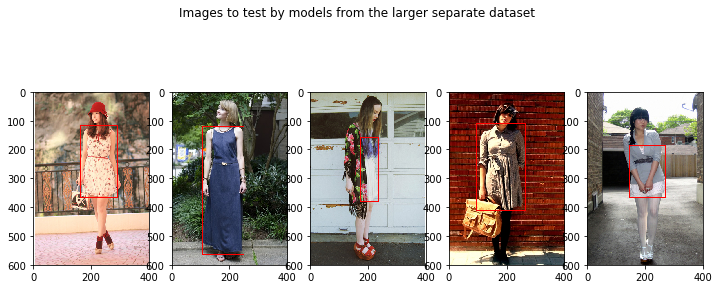

In [20]:
plt.figure(figsize=[12,5])
i = 1
for ind in test_dresses_large:
    plt.subplot(1,5,i)
    i += 1
    print_image(ind=ind, directory='', df=test_large_dresses, column='url')
plt.suptitle('Images to test by models from the larger separate dataset')    
plt.show()

In [21]:
# combine all test image indexes to a dataframe
all_tests = pd.DataFrame([['test_nums', test_numbers],['all_nums', all_test_numbers],
                          ['small_nums', test_dresses_small],
                        ['large_nums', test_dresses_large]], 
                         columns=['origin', 'random_nums'])
all_tests.to_csv('data/images_to_test.csv')